In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
COLORS = {'green': '#00afa5', 'blue': '#005ae8', 'orange': '#f17900', 'red': '#ae0060', 'gray': '#c5d5db'}
dataset = pd.read_excel('ACTION_patients_overlap_only.xlsx')
dataset['P_NUMBER'] = dataset['P_NUMBER'].fillna(method='ffill')
overlap_array = np.array(dataset['TOTAL_OVERLAP (cc)']).reshape(len(dataset['P_NUMBER'].unique()), 6)
import re
prescription_doses = []
for entry in dataset['PRESCRIPTION_DOSE']:
    if type(entry) == str:
        match = re.search(r'(\d+(?:\.\d+)?)\s*x\s*(\d+(?:\.\d+)?)', entry)
        if match:
            result = float(match.group(1)) * float(match.group(2))
            prescription_doses.append(result)


/tmp/ipykernel_57505/4095656983.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset['P_NUMBER'] = dataset['P_NUMBER'].fillna(method='ffill')


## Prior calculation

In [13]:
from adaptive_fractionation_overlap.helper_functions import hyperparam_fit
alpha, beta = hyperparam_fit(overlap_array)
observed_stds = overlap_array.std(axis=1)
observed_means = overlap_array.mean(axis=1)

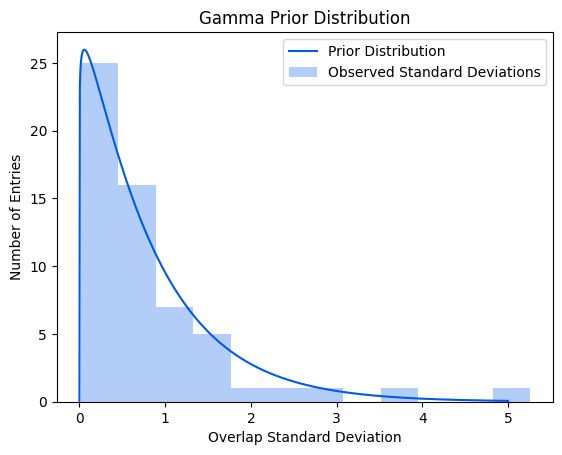

In [14]:
# Calculate the histogram (to get bin width and counts)
counts, bins = np.histogram(observed_stds, bins=12)
bin_width = bins[1] - bins[0]
n_entries = len(observed_stds)

# Rescale the PDF
x = np.linspace(0, 5, 1000)
y = gamma.pdf(x, a=alpha, scale=beta)
y_scaled = y * n_entries * bin_width

plt.plot(x, y_scaled, label='Prior Distribution', color=COLORS['blue'])
plt.xlabel('Overlap Standard Deviation')
plt.ylabel('Number of Entries')
plt.title('Gamma Prior Distribution')
plt.hist(observed_stds, bins=12, density=False, alpha=0.3, label='Observed Standard Deviations', color=COLORS['blue'])
plt.legend()
plt.show()

## Single Patient Illustrations

We take a look at patients 3 and 49

In [23]:
import adaptive_fractionation_overlap as afx
overlaps_49 = overlap_array[48]
overlaps_3 = overlap_array[2]

## per fraction analysis. only works with the dev branch

## Patient 3

first fraction

In [28]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 1, volumes = overlaps_3[:2],accumulated_dose =  0, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 6.6, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

ValueError: not enough values to unpack (expected 11, got 9)

In [136]:
closest_index = np.abs((volume_space - overlaps_3[1])).argmin()

In [137]:
values_actual_frac[closest_index]

-35.30258192968879

In [138]:
volume_space[74]

11.803286735561919

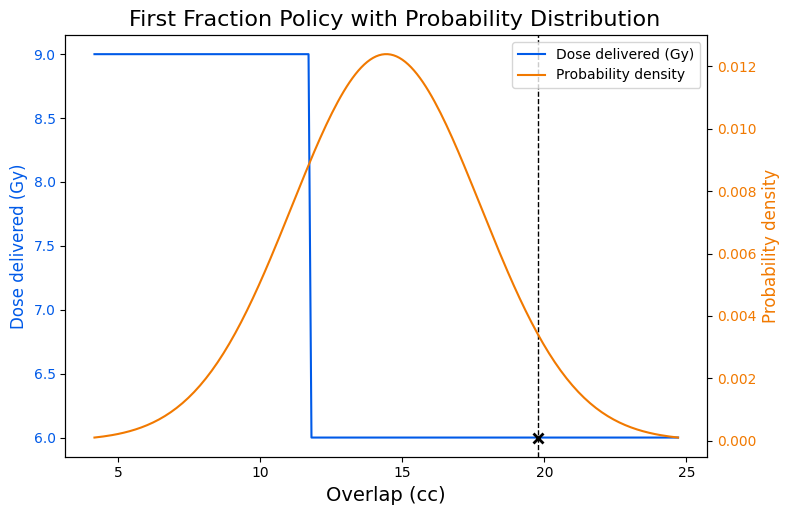

In [139]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, policies_overlap, color=COLORS['blue'], label='Dose delivered (Gy)')
ax1.set_xlabel('Overlap (cc)',fontsize = 14)
ax1.set_ylabel('Dose delivered (Gy)', color=COLORS['blue'],fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at 19.79
ax1.axvline(x=19.79, color='k', linestyle='--', linewidth=1)

# Add black cross at (19.79, 6)
ax1.plot(19.79, 6, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
fig.suptitle('First Fraction Policy with Probability Distribution', fontsize=16, y=1.02)
plt.show()


In [140]:
from scipy.stats import norm, gamma

distribution = norm(loc = 14.4, scale = 3.2)

In [141]:
distribution.cdf(11.75)

0.20379985633185305

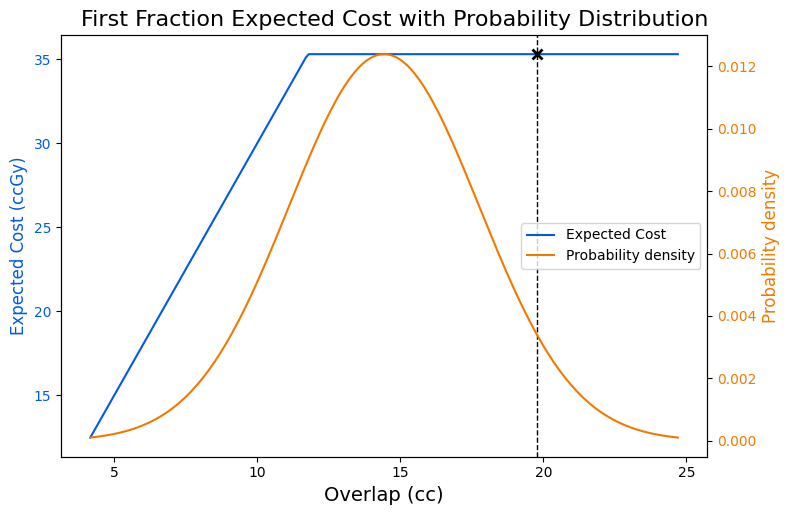

In [71]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, values_actual_frac*-1, color=COLORS['blue'], label='Expected Cost')
ax1.set_xlabel('Overlap (cc)', fontsize = 14)
ax1.set_ylabel('Expected Cost (ccGy)', color=COLORS['blue'], fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at 19.79
ax1.axvline(x=19.79, color='k', linestyle='--', linewidth=1)

# Add black cross at (19.79, values_actual_frac[closest_index])
ax1.plot(19.79, values_actual_frac[closest_index]*-1, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

fig.tight_layout()
fig.suptitle('First Fraction Expected Cost with Probability Distribution', fontsize=16, y=1.02)
plt.show()


Fraction 2

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(2, overlaps_3[:3], 6, 0, 0, 5, 6, 10, 6.6,0.01, alpha, beta )
physical_dose

8.99

In [146]:
policies_overlap[0][79]

8.989999999999936

In [147]:
volume_space[80]

9.275336155533479

In [148]:
distribution = norm(loc = 11.63, scale = 3.88)
distribution.cdf(9.2)

0.2655628115734442

In [149]:
values_smoothed = values_actual_frac.copy()
values_smoothed[values_smoothed < -1000] = 123412341234
values_smoothed[values_smoothed == 123412341234] = values_smoothed.min()-0.5


In [150]:
from matplotlib.colors import LinearSegmentedColormap

# Create a continuous colormap from your COLORS
continuous_cmap = LinearSegmentedColormap.from_list(
    "custom_continuous",
    [COLORS['gray'], COLORS['orange'], COLORS['red']]
)


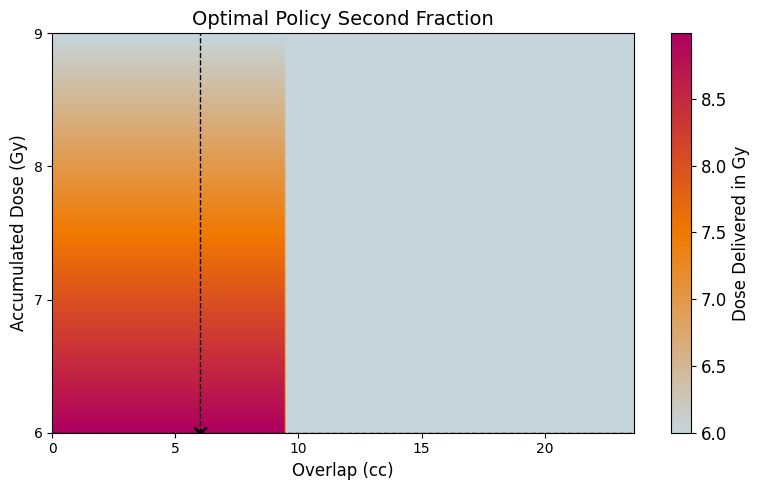

In [151]:
fig, ax1 = plt.subplots(figsize=(8, 5))
upper_limit = np.where(dose_space_adapted.round(2) == 9.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap=continuous_cmap,
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([6, 7, 8, 9, 10])
ax1.set_title('Optimal Policy Second Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=6.01, color='k', linestyle='--', linewidth=1)
ax1.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(6.01, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

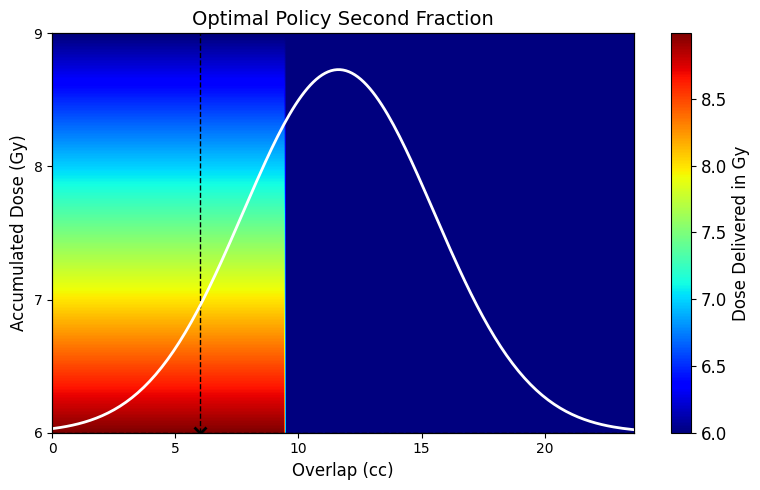

In [152]:
fig, ax1 = plt.subplots(figsize=(8, 5))
upper_limit = np.where(dose_space_adapted.round(2) == 9.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([6, 7, 8, 9])
ax1.set_title('Optimal Policy Second Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=6.01, color='k', linestyle='--', linewidth=1)
ax1.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(6.01, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white
pdf = distribution.pdf(volume_space)
# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, pdf, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, pdf.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

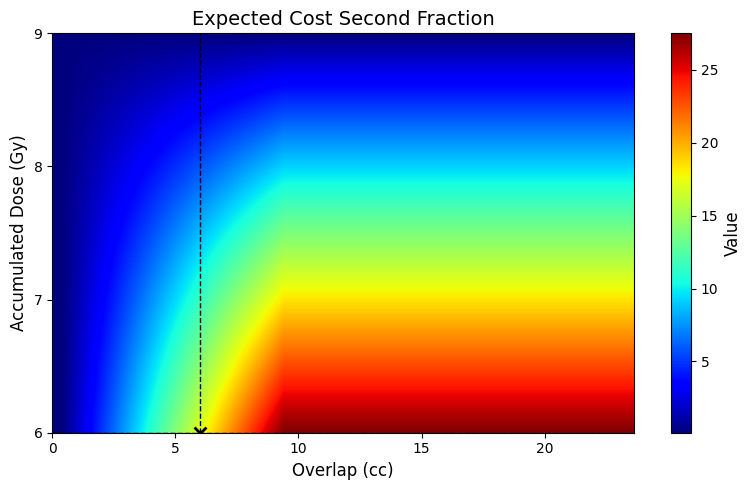

In [153]:
fig, ax1 = plt.subplots(figsize=(8, 5))


im = ax1.imshow(
    values_smoothed[:upper_limit] *-1,
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)

# Overlay grey for y > 9
# ymin, ymax = 9, dose_space_adapted[8]
# ax1.axhspan(ymin, ymax, color='white', alpha=1, zorder=2)

ax1.set_xlabel('Overlap (cc)', fontsize = 12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize = 12)
ax1.set_yticks([6, 7, 8, 9])
ax1.set_title('Expected Cost Second Fraction', fontsize=14)
fig.colorbar(im, ax=ax1).set_label('Value', fontsize=12)

# Add vertical and horizontal lines
plt.axvline(x=6.01, color='k', linestyle='--', linewidth=1)
plt.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(6.01, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

fig.tight_layout()
plt.show()

third fraction

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(3, overlaps_3[:4], 15, 0, 0, 5, 6, 10, 6.6,0.01, alpha, beta )
print(penalty_added)

0.0


In [79]:
policies_overlap[0][87]

6.0

In [80]:
volume_space[86]

9.516901214689321

In [81]:
distribution = norm(loc = 11.085, scale = 3.7399999)
distribution.cdf(9.56)

0.34172713617898154

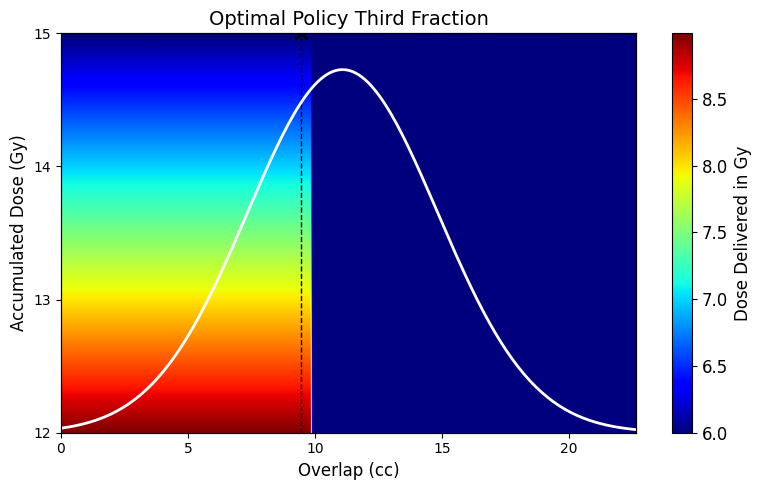

In [82]:
fig, ax1 = plt.subplots(figsize=(8, 5))
upper_limit = np.where(dose_space_adapted.round(2) == 15.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([12, 13, 14, 15])
ax1.set_title('Optimal Policy Third Fraction', fontsize=14)

# Add vertical and horizontal lines
plt.axvline(x=9.45, color='k', linestyle='--', linewidth=1)
plt.axhline(y=15, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(9.45, 15, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white
pdf = distribution.pdf(volume_space)
# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, pdf, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, pdf.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

fourth fraction

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(4, overlaps_3[:5], 21, 0, 0, 5, 6, 10, 6.6,0.05, alpha, beta )

In [96]:
policies_overlap[0][99]

8.99999999999999

In [97]:
volume_space[100]

12.851469444235194

In [98]:
distribution = norm(loc = 12.786, scale = 4.216)

In [99]:
distribution.cdf(12.78)

0.4994322455231478

In [100]:
dose_space_adapted

array([18.  , 18.05, 18.1 , 18.15, 18.2 , 18.25, 18.3 , 18.35, 18.4 ,
       18.45, 18.5 , 18.55, 18.6 , 18.65, 18.7 , 18.75, 18.8 , 18.85,
       18.9 , 18.95, 19.  , 19.05, 19.1 , 19.15, 19.2 , 19.25, 19.3 ,
       19.35, 19.4 , 19.45, 19.5 , 19.55, 19.6 , 19.65, 19.7 , 19.75,
       19.8 , 19.85, 19.9 , 19.95, 20.  , 20.05, 20.1 , 20.15, 20.2 ,
       20.25, 20.3 , 20.35, 20.4 , 20.45, 20.5 , 20.55, 20.6 , 20.65,
       20.7 , 20.75, 20.8 , 20.85, 20.9 , 20.95, 21.  , 21.05, 21.1 ,
       21.15, 21.2 , 21.25, 21.3 , 21.35, 21.4 , 21.45, 21.5 , 21.55,
       21.6 , 21.65, 21.7 , 21.75, 21.8 , 21.85, 21.9 , 21.95, 22.  ,
       22.05, 22.1 , 22.15, 22.2 , 22.25, 22.3 , 22.35, 22.4 , 22.45,
       22.5 , 22.55, 22.6 , 22.65, 22.7 , 22.75, 22.8 , 22.85, 22.9 ,
       22.95, 23.  , 23.05, 23.1 , 23.15, 23.2 , 23.25, 23.3 , 23.35,
       23.4 , 23.45, 23.5 , 23.55, 23.6 , 23.65, 23.7 , 23.75, 23.8 ,
       23.85, 23.9 , 23.95, 24.  , 24.05, 24.1 , 24.15, 24.2 , 24.25,
       24.3 , 24.35,

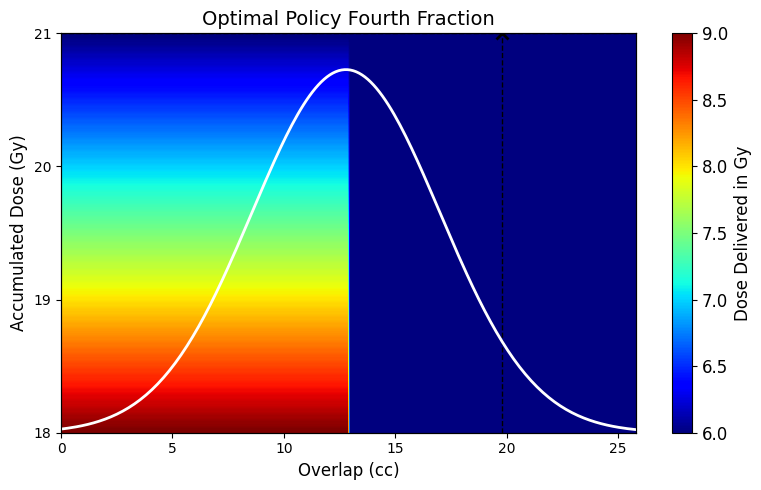

In [101]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 21.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[ upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([18,19, 20, 21])
ax1.set_title('Optimal Policy Fourth Fraction', fontsize=14)

# Add vertical and horizontal lines
plt.axvline(x=19.79, color='k', linestyle='--', linewidth=1)
plt.axhline(y=21, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(19.79, 21, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white
pdf = distribution.pdf(volume_space)
# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, pdf, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, pdf.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

fifth fraction

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(5, overlaps_3, 27, 0, 0, 5, 6, 10, 6.6,0.01, alpha, beta )

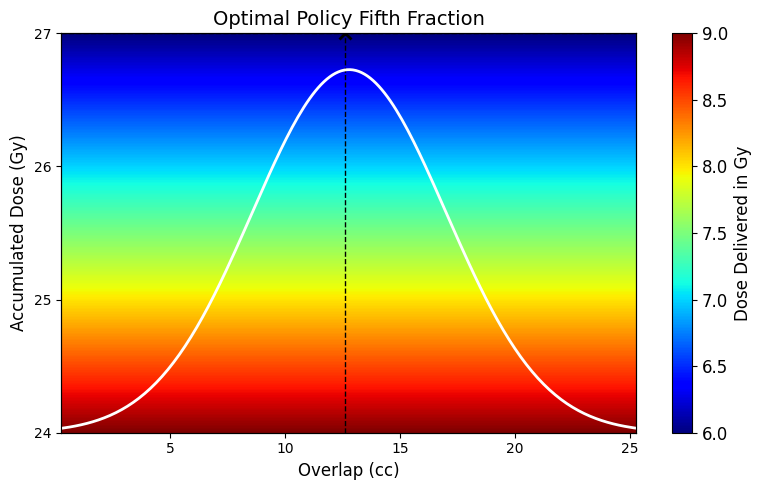

In [45]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 27.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([24,25, 26, 27,28])
ax1.set_title('Optimal Policy Fifth Fraction', fontsize=14)

# Add vertical and horizontal lines
plt.axvline(x=12.62, color='k', linestyle='--', linewidth=1)
plt.axhline(y=27, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(12.62, 27, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white
pdf = distribution.pdf(volume_space)
# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, pdf, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, pdf.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

## Patient 49

In [ ]:
afx.adaptfx_full(overlaps_49,5, 0, 0, 6, 10, 8 ,0.01, alpha, beta )

0 6.0
benefit 0.0
penalty 0.0
1 10.0
benefit 0
penalty 13.120000000000001
2 10.0
benefit 0
penalty 15.48
3 8.0
benefit 0
penalty 8.36
4 6.0
benefit 0.0
penalty 0.0


(array([ 6., 10., 10.,  8.,  6.]), array([ 0.,  6., 16., 26., 34.]), -36.96)

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(1, overlaps_49[:2], 0, 0, 0, 5, 6, 10, 8 ,0.01, alpha, beta )

In [ ]:
print(volume_space[np.where(np.round(policies_overlap,2) == 8)[0][0]])
print(volume_space[np.where(np.round(policies_overlap,2) == 6)[0][0]])
std = afx.std_calc(overlaps_49[:2], alpha,beta)
mean = overlaps_49[:2].mean()
distribution = norm(loc = mean, scale = std)
distribution.cdf(5.2817031046213145)

4.974978137227211
5.2817031046213145


0.5920929276785487

In [157]:
dose_space_adapted[8]

0.08

In [158]:
overlaps_49

array([4.27, 5.91, 3.28, 3.87, 4.18, 8.36])

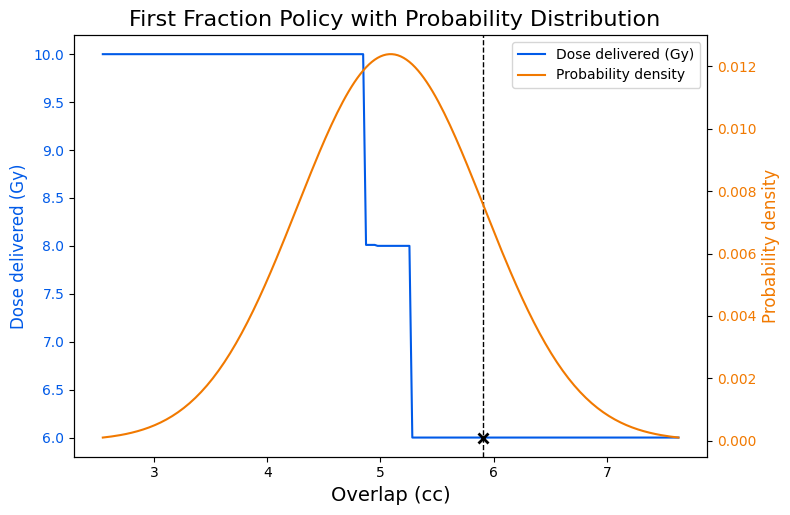

In [159]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, policies_overlap, color=COLORS['blue'], label='Dose delivered (Gy)')
ax1.set_xlabel('Overlap (cc)',fontsize = 14)
ax1.set_ylabel('Dose delivered (Gy)', color=COLORS['blue'],fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at overlaps_49[1]
ax1.axvline(x=overlaps_49[1], color='k', linestyle='--', linewidth=1)

# Add black cross at (overlaps_49[1], physical_dose)
ax1.plot(overlaps_49[1], physical_dose, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
fig.suptitle('First Fraction Policy with Probability Distribution', fontsize=16, y=1.02)
plt.show()


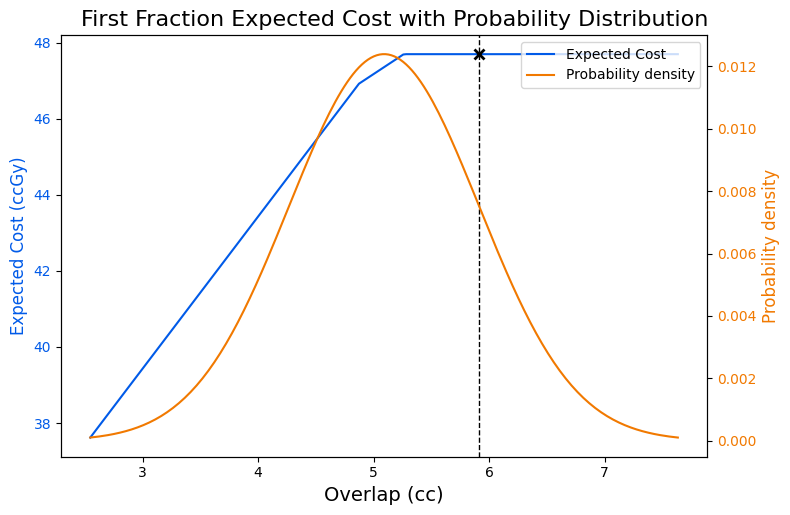

In [160]:
closest_index = np.abs((volume_space - overlaps_49[1])).argmin()
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, values_actual_frac *-1, color=COLORS['blue'], label='Expected Cost')
ax1.set_xlabel('Overlap (cc)', fontsize = 14)
ax1.set_ylabel('Expected Cost (ccGy)', color=COLORS['blue'], fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at overlaps_49[1]
ax1.axvline(x=overlaps_49[1], color='k', linestyle='--', linewidth=1)

# Add black cross at (overlaps_49[1], values_actual_frac[closest_index])
ax1.plot(overlaps_49[1], values_actual_frac[closest_index] *-1, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
fig.suptitle('First Fraction Expected Cost with Probability Distribution', fontsize=16, y=1.02)
plt.show()


fraction 2

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(2, overlaps_49[:3], 6, 0, 0, 5, 6, 10, 8,0.01, alpha, beta )
physical_dose

10.0

In [162]:
policies_overlap.shape

(3400, 200)

In [163]:
np.where(np.round(policies_overlap[8],1) == 8)

(array([], dtype=int64),)

In [164]:
policies_overlap[20]

array([10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
       10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  , 10.  ,
        7.8 ,  7.8 ,  7.8 ,  7.8 ,  7.8 ,  7.8 ,  7.8 ,  7.8 ,  7.8 ,
        7.8 ,  7.8 ,  7.8 ,  7.8 ,  7.79,  7.79,  7.79,  7.79,  7.79,
        7.79,  7.79,  7.79,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,
        6.  ,  6.  ,

In [ ]:
print(volume_space[np.where(policies_overlap[8] == 8)[0][0]])
print(volume_space[np.where(policies_overlap[0] == 8)[0][0]])
print(volume_space[np.where(policies_overlap[0] == 6)[0][0]])
std = afx.std_calc(overlaps_49[:3], alpha,beta)
mean = overlaps_49[:3].mean()
distribution = norm(loc = mean, scale = std)
distribution.cdf(4.47051670888569
)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [165]:
policies_overlap

array([[10., 10., 10., ...,  6.,  6.,  6.],
       [10., 10., 10., ...,  6.,  6.,  6.],
       [10., 10., 10., ...,  6.,  6.,  6.],
       ...,
       [ 6.,  6.,  6., ...,  6.,  6.,  6.],
       [ 6.,  6.,  6., ...,  6.,  6.,  6.],
       [ 6.,  6.,  6., ...,  6.,  6.,  6.]])

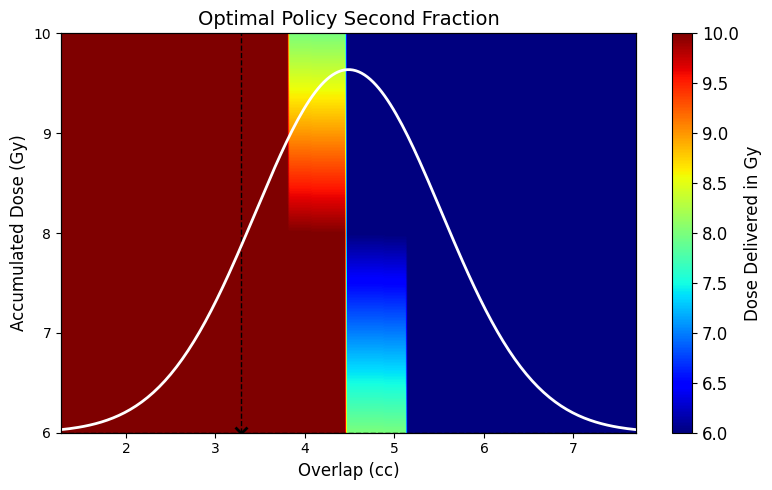

In [166]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 10.00)[0][0]

im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([6, 7, 8, 9, 10])
ax1.set_title('Optimal Policy Second Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[2], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[2], 6, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

In [167]:
values_smoothed = values_actual_frac.copy()
values_smoothed[values_smoothed < -1000] = 123412341234
values_smoothed[values_smoothed == 123412341234] = values_smoothed.min()-0.5

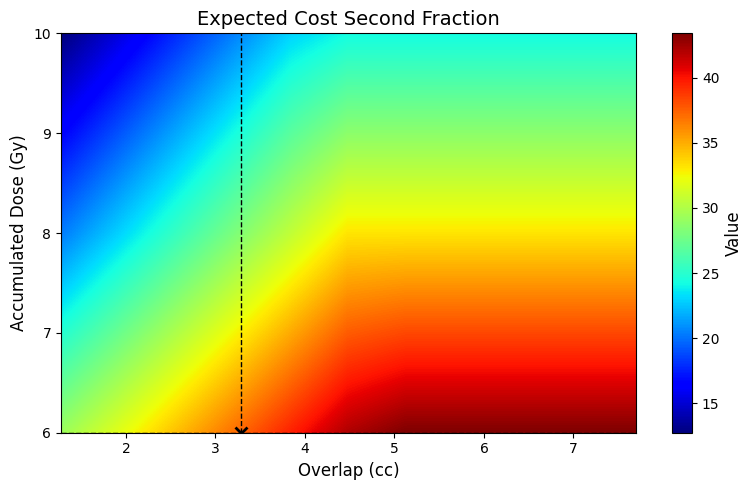

In [168]:
fig, ax1 = plt.subplots(figsize=(8, 5))


im = ax1.imshow(
    values_smoothed[:upper_limit+1] *-1,
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)

ax1.set_yticks([6, 7, 8, 9, 10])

ax1.set_xlabel('Overlap (cc)', fontsize = 12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize = 12)
ax1.set_title('Expected Cost Second Fraction', fontsize=14)
fig.colorbar(im, ax=ax1).set_label('Value', fontsize=12)

# Add vertical and horizontal lines
plt.axvline(x=3.28, color='k', linestyle='--', linewidth=1)
plt.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(3.28, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

fig.tight_layout()
plt.show()

fraction 3

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(3, overlaps_49[:4], 16, 0, 0, 5, 6, 10, 8,0.01, alpha, beta )
physical_dose

10.0

In [ ]:
dose_space_adapted

array([12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
       23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. ,
       28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5,
       34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. ,
       39.5])

In [ ]:
dose_space_adapted[8]

16.0

In [ ]:
print(volume_space[np.where(policies_overlap[16] == 6)[0][0]])
print(volume_space[np.where(policies_overlap[8] == 6)[0][0]])
print(volume_space[np.where(policies_overlap[0] == 8)[0][0]])
# print(volume_space[np.where(policies_overlap[0] == 6)[0][0]])
std = afx.std_calc(overlaps_49[:4], alpha,beta)
mean = overlaps_49[:4].mean()
distribution = norm(loc = mean, scale = std)
distribution.cdf(4.704414893129242)

3.9605851068707585
4.704414893129242
4.704414893129242


0.6510734345363951

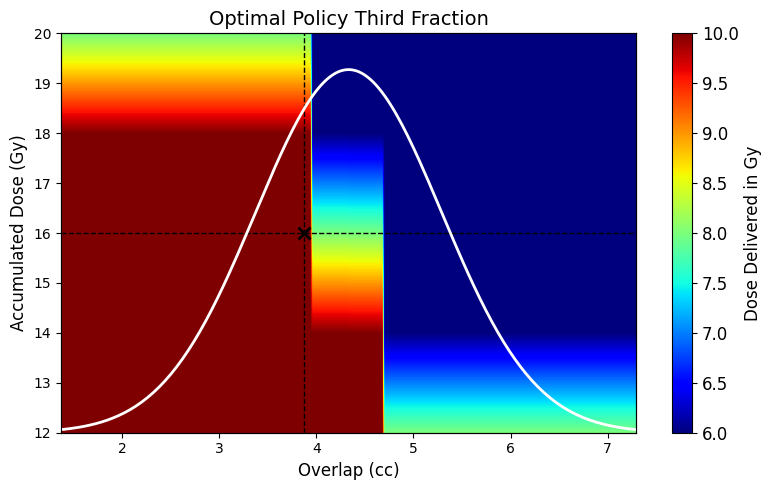

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 20.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([12, 13, 14, 15, 16, 17, 18, 19, 20])
ax1.set_title('Optimal Policy Third Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[3], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=16, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[3], 16, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

fraction 4

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(4, overlaps_49[:5], 26, 0, 0, 5, 6, 10, 8,0.01, alpha, beta )
physical_dose

8.0

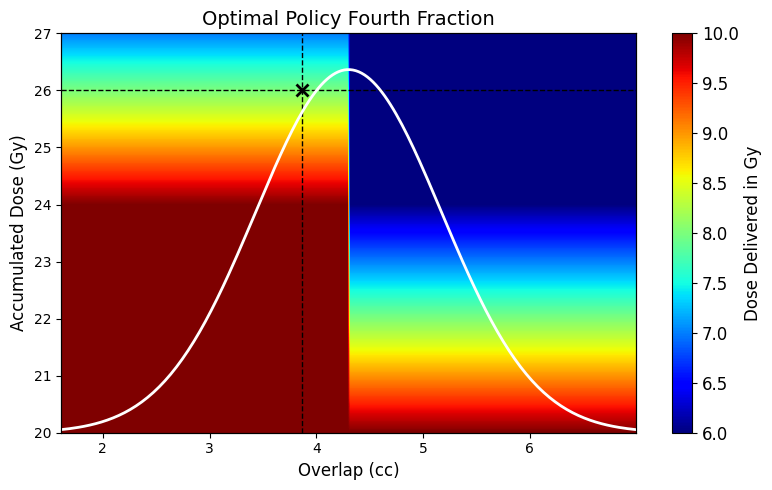

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 27.00)[0][0]
lower_limit = np.where(dose_space_adapted.round(2) == 20.00)[0][0]
im = ax1.imshow(
    policies_overlap[lower_limit:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[lower_limit], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([20, 21, 22, 23, 24, 25, 26, 27, 28])
ax1.set_title('Optimal Policy Fourth Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[3], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=26, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[3], 26, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

fifth fraction

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(5, overlaps_49[:5], 34, 0, 0, 5, 6, 10, 8,0.01, alpha, beta )
physical_dose

6

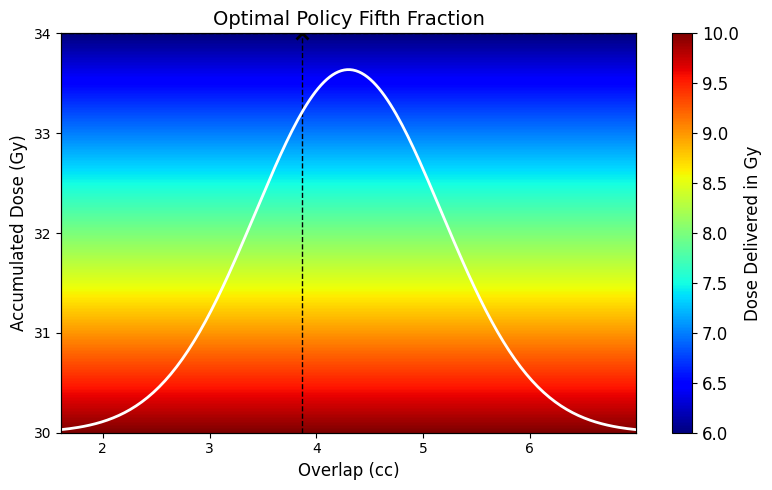

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))
lower_limit = np.where(dose_space_adapted.round(2) == 30.00)[0][0]
upper_limit = np.where(dose_space_adapted.round(2) == 34.00)[0][0]
im = ax1.imshow(
    policies_overlap[lower_limit:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[lower_limit], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([30, 31, 32, 33, 34])
ax1.set_title('Optimal Policy Fifth Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[3], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=34, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[3], 34, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

In [ ]:
d_mean = 40 / 5
standard_penalty = -(overlaps_49[1:] * (d_mean - 6))
standard_penalty.sum()
# adapt_doses = np.array([6, 10, 10, 8, 6])
# adapt_penalty = -(overlaps_49[1:] * (adapt_doses - 6))
# adapt_penalty.sum()

-51.2

## Percentile Analysis

In [ ]:
thirty_three_pats = np.where(df.sort_index()['Prescription'] == 33)[0]
thirty_five_pats = np.where(df.sort_index()['Prescription'] == 35)[0]
fourty_pats = np.where(df.sort_index()['Prescription'] == 40)[0]
fourty_five_pats = np.where(df.sort_index()['Prescription'] == 45)[0]


NameError: name 'df' is not defined

In [ ]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(1, overlaps_7[:2], 0, 0, 0, 5, 6, 10, 8 ,0.5, alpha, beta )

NameError: name 'overlaps_7' is not defined

In [ ]:
def percentiles_40_first_fraction(overlaps, new_alpha, new_beta):
    policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(1, overlaps[:2], 0, 0, 0, 5, 6, 10, 8 ,0.5, new_alpha, new_beta )
    lower_volume = volume_space[np.where(policies_overlap == 8)[0][0]]
    upper_volume = volume_space[np.where(policies_overlap == 6)[0][0]]
    std = afx.std_calc(overlaps[:2], new_alpha, new_beta)
    mean = overlaps[:2].mean()
    distribution = norm(loc=mean, scale=std)
    lower_percentile = distribution.cdf(lower_volume)
    upper_percentile = distribution.cdf(upper_volume)
    
    return lower_percentile, upper_percentile

In [ ]:
fourty_pats

NameError: name 'fourty_pats' is not defined

In [ ]:
for index in fourty_pats:
    print(percentiles_40_first_fraction(overlap_array[index], alpha, beta))

(0.40790707232145107, 0.5920929276785487)
(0.420007429688227, 0.6041060701210588)
(0.4079070723214512, 0.5920929276785488)
(0.42000742968822713, 0.604106070121059)
(0.4567195709488417, 0.6278275114075198)
(0.4444251054916788, 0.616021128662296)
(0.3958939298789415, 0.5920929276785487)
(0.31511861523687024, 0.5061948481256001)
(0.40790707232145146, 0.592092927678549)
(0.44442510549167885, 0.6160211286622963)
(0.4200074296882269, 0.6041060701210587)


: 

## Full Analysis

In [ ]:
import Overlap_adaptfx.adaptive_fractionation_overlap as afx

phys_doses = []
accum_doses = []
total_penalties = []
for index, patient_overlaps in enumerate(overlap_array):
    physical_doses, accumulated_doses, total_penalty = afx.adaptfx_full(patient_overlaps, number_of_fractions=5, steepness_penalty = 0, steepness_benefit=0, min_dose = 6, max_dose = 10, mean_dose = prescription_doses[index]/5, dose_steps = 0.25, alpha = alpha, beta = beta)
    phys_doses.append(physical_doses)
    accum_doses.append(accumulated_doses)
    total_penalties.append(total_penalty)

0 6.0
benefit 0.0
penalty 0.0
1 6.0
benefit 0.0
penalty 0.0
2 9.0
benefit 0
penalty 5.88
3 6.0
benefit 0.0
penalty 0.0
4 6.0
benefit 0.0
penalty 0.0
0 6.0
benefit 0.0
penalty 0.0
1 9.0
benefit 0
penalty 14.73
2 6.0
benefit 0.0
penalty 0.0
3 6.0
benefit 0.0
penalty 0.0
4 6.0
benefit 0.0
penalty 0.0
0 6.0
benefit 0.0
penalty 0.0
1 9.0
benefit 0
penalty 18.06
2 6.0
benefit 0.0
penalty 0.0
3 6.0
benefit 0.0
penalty 0.0
4 6.0
benefit 0.0
penalty 0.0
0 6.0
benefit 0.0
penalty 0.0
1 6.0
benefit 0.0
penalty 0.0
2 6.0
benefit 0.0
penalty 0.0
3 9.0
benefit 0
penalty 54.269999999999996
4 6.0
benefit 0.0
penalty 0.0
0 6.0
benefit 0.0
penalty 0.0
1 6.0
benefit 0.0
penalty 0.0
2 6.0
benefit 0.0
penalty 0.0
3 6.0
benefit 0.0
penalty 0.0
4 9.0
benefit 0
penalty 68.94
0 6.0
benefit 0.0
penalty 0.0
1 6.0
benefit 0.0
penalty 0.0
2 6.0
benefit 0.0
penalty 0.0
3 7.0
benefit 0
penalty 2.41
4 10.0
benefit 0
penalty 1.08
0 6.0
benefit 0.0
penalty 0.0
1 6.0
benefit 0.0
penalty 0.0
2 10.0
benefit 0
penalty 32.7

In [ ]:
standard_penalties  = []
for index, patient_overlaps in enumerate(overlap_array):
    d_mean = prescription_doses[index] / 5
    standard_penalty = -(patient_overlaps[1:] * (d_mean - 6)).sum()
    standard_penalties.append(standard_penalty)
benefits = np.array(total_penalties) - np.array(standard_penalties)

In [ ]:
benefits

array([ 3.708,  6.348, 22.422,  0.984, -2.976,  3.37 ,  7.46 ,  6.18 ,
        3.57 ,  2.472,  0.59 ,  0.08 ,  5.38 ,  8.77 ,  1.1  , -4.44 ,
        2.8  ,  3.57 ,  0.97 ,  4.05 ,  5.214,  0.56 ,  3.6  ,  3.97 ,
        1.57 ,  5.69 ,  6.276,  2.088,  3.88 ,  4.8  ,  2.478, -0.74 ,
        4.11 ,  0.594,  1.02 ,  0.738,  1.35 ,  1.2  ,  0.85 ,  3.11 ,
        0.34 ,  0.74 ,  3.32 ,  0.3  ,  1.98 ,  0.98 ,  1.94 ,  0.13 ,
       14.24 ,  0.38 ,  0.11 ,  1.28 ,  0.77 ,  3.58 ,  8.76 ,  1.82 ,
        0.12 ,  0.64 ])

In [ ]:
df = pd.DataFrame({
    'Patient number': dataset['P_NUMBER'].unique(),
    'Overlaps': overlap_array.tolist(),
    'Prescription': prescription_doses,
    'AF doses': phys_doses,
    'benefits': benefits,
    'penalties': total_penalties
})

In [ ]:
df

,Patient number,Overlaps,Prescription,AF doses,benefits,penalties
0,1.0,"[2.02, 2.41, 3.04, 1.96, 5.3, 3.27]",33.0,"[6.0, 6.0, 9.0, 6.0, 6.0]",3.708,-5.88
1,2.0,"[6.19, 10.97, 4.91, 7.65, 5.73, 5.87]",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.348,-14.73
2,3.0,"[9.08, 19.79, 6.02, 9.45, 19.59, 12.62]",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",22.422,-18.06
3,4.0,"[15.07, 19.81, 16.12, 22.630000000000003, 18.0...",33.0,"[6.0, 6.0, 6.0, 9.0, 6.0]",0.984,-54.27
4,5.0,"[17.150000000000002, 18.68, 18.35, 28.56000000...",33.0,"[6.0, 6.0, 6.0, 6.0, 9.0]",-2.976,-68.94
5,6.0,"[0.25, 0.53, 0.99, 2.66, 2.41, 0.27]",35.0,"[6.0, 6.0, 6.0, 7.0, 10.0]",3.370,-3.49
6,7.0,"[5.41, 8.2, 9.16, 8.18, 5.45, 7.28]",40.0,"[6.0, 6.0, 10.0, 10.0, 8.0]",7.460,-69.08
7,8.0,"[0.41, 2.37, 0.68, 2.67, 1.62, 1.27]",40.0,"[6.0, 10.0, 6.0, 8.0, 10.0]",6.180,-11.04
8,9.0,"[9.52, 12.18, 8.52, 9.39, 9.639999999999999, 8...",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",3.570,-25.56
9,10.0,"[4.58, 5.78, 6.3, 3.83, 4.67, 2.69]",33.0,"[6.0, 6.0, 9.0, 6.0, 6.0]",2.472,-11.49


In [ ]:
import scipy.optimize as opt
# upper bound code
def calc_upper_bound_treatment(overlaps, prescription_dose, number_of_fractions, min_dose = 6, max_dose = 10):
    """
    Calculate the upper bound treatment for a given overlap and prescription dose.

    Parameters
    ----------
    overlaps : array
        The overlaps for the patient.
    prescription_dose : float
        The prescription dose for the patient.
    number_of_fractions : int
        The number of fractions in the treatment.

    Returns
    -------
    float
        The upper bound treatment value.
    """
    # Objective: minimize sum((dose_i - min_dose) * overlaps_i)
    def penalty(doses):
        return np.sum((doses - min_dose) * overlaps[1:])  # skip planning scan

    # Constraints: sum(doses) == prescription_dose, min_dose <= doses <= max_dose
    cons = ({
        'type': 'eq',
        'fun': lambda doses: np.sum(doses) - prescription_dose
    })
    bounds = [(min_dose, max_dose)] * number_of_fractions

    # Initial guess: equal split
    x0 = np.full(number_of_fractions, prescription_dose / number_of_fractions)

    res = opt.minimize(penalty, x0, bounds=bounds, constraints=cons)
    if res.success:
        # Calculate the minimized penalty value
        total_penalty = penalty(res.x)
        return res.x, total_penalty
    else:
        return None, None

# Calculate upper bounds for all patients and store in a DataFrame
upper_bound_doses = []
upper_bound_penalties = []

for overlaps, prescription, n_fractions in zip(overlap_array, prescription_doses, [5]*len(overlap_array)):
    doses, penalty = calc_upper_bound_treatment(overlaps, prescription, n_fractions)
    upper_bound_doses.append(np.round(doses))
    upper_bound_penalties.append(penalty)
upper_bound_benefits = -np.array(upper_bound_penalties) - np.array(standard_penalties)
df_upper_bounds = pd.DataFrame({
    'Patient number': dataset['P_NUMBER'].unique(),
    'Upper Bound Doses': upper_bound_doses,
    'Upper Bound Benefits': upper_bound_benefits
})

df_upper_bounds
    

,Patient number,Upper Bound Doses,Upper Bound Benefits
0,1.0,"[6.0, 6.0, 9.0, 6.0, 6.0]",3.708
1,2.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.348
2,3.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",22.422
3,4.0,"[6.0, 6.0, 6.0, 6.0, 9.0]",8.934
4,5.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",10.914
5,6.0,"[7.0, 6.0, 6.0, 6.0, 10.0]",5.250
6,7.0,"[6.0, 6.0, 8.0, 10.0, 10.0]",9.260
7,8.0,"[6.0, 10.0, 6.0, 8.0, 10.0]",6.180
8,9.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",3.570
9,10.0,"[6.0, 6.0, 6.0, 6.0, 9.0]",5.892


In [ ]:
df = pd.concat([df, df_upper_bounds[['Upper Bound Doses', 'Upper Bound Benefits']]], axis=1)
df[['Patient number','Prescription']]

,Patient number,Prescription
0,1.0,33.0
1,2.0,33.0
2,3.0,33.0
3,4.0,33.0
4,5.0,33.0
5,6.0,35.0
6,7.0,40.0
7,8.0,40.0
8,9.0,33.0
9,10.0,33.0


In [ ]:
# ...existing code...

# Build the new table
rows = []
for idx, row in df.iterrows():
    patient_number = row['Patient number']
    overlaps = row['Overlaps']  # 6 entries: [Planning, F1, F2, F3, F4, F5]
    af_doses = row['AF doses']  # 5 entries: [F1, F2, F3, F4, F5]
    upper_bound_doses = row['Upper Bound Doses']  # 5 entries: [F1, F2, F3, F4, F5]
    upper_bound_benefits = row['Upper Bound Benefits']
    benefits = row['benefits']

    # Overlap row
    rows.append({
        'Patient number': patient_number,
        'Plan type': 'Overlap',
        'Planning scan': overlaps[0],
        'Fraction 1': overlaps[1],
        'Fraction 2': overlaps[2],
        'Fraction 3': overlaps[3],
        'Fraction 4': overlaps[4],
        'Fraction 5': overlaps[5],
        'benefits': np.nan
    })
    # AF row
    rows.append({
        'Patient number': patient_number,
        'Plan type': 'AF',
        'Planning scan': np.nan,
        'Fraction 1': af_doses[0],
        'Fraction 2': af_doses[1],
        'Fraction 3': af_doses[2],
        'Fraction 4': af_doses[3],
        'Fraction 5': af_doses[4],
        'benefits': benefits
    })
    # Upper Bound row (copy of AF for now)
    rows.append({
        'Patient number': patient_number,
        'Plan type': 'Upper Bound',
        'Planning scan': np.nan,
        'Fraction 1': upper_bound_doses[0],
        'Fraction 2': upper_bound_doses[1],
        'Fraction 3': upper_bound_doses[2],
        'Fraction 4': upper_bound_doses[3],
        'Fraction 5': upper_bound_doses[4],
        'benefits': upper_bound_benefits
    })

# Create the new DataFrame
df_long = pd.DataFrame(rows)
df_long = df_long[['Patient number', 'Plan type', 'Planning scan', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Fraction 4', 'Fraction 5', 'benefits']]

df_long.replace({np.nan: ''}, inplace=True)
# df_long.to_excel('ACTION_patients_overlap_adaptfx_long.xlsx', index=False)

In [ ]:
indexes_equal = np.round(df['benefits'],2) == np.round(df['Upper Bound Benefits'],2)

In [ ]:
df.loc[~indexes_equal][['benefits', 'Upper Bound Benefits']]

,benefits,Upper Bound Benefits
3,0.984,8.934
4,-2.976,10.914
5,3.370,5.250
6,7.460,9.260
9,2.472,5.892
10,0.590,1.430
12,5.380,5.490
14,1.100,1.530
15,-4.440,17.680
17,3.570,3.820


In [ ]:
(df.loc[~indexes_equal]['benefits'] - df.loc[~indexes_equal]['Upper Bound Benefits'])

3     -7.95
4    -13.89
5     -1.88
6     -1.80
9     -3.42
10    -0.84
12    -0.11
14    -0.43
15   -22.12
17    -0.25
19    -0.03
20    -1.11
21    -0.09
22    -2.94
31    -1.98
32    -0.84
34    -0.87
36    -0.57
37    -0.79
40    -0.06
41    -0.57
42    -1.14
44    -0.32
45    -1.20
46    -0.96
49    -0.02
52    -2.39
53    -1.22
56    -0.57
57    -0.96
dtype: float64

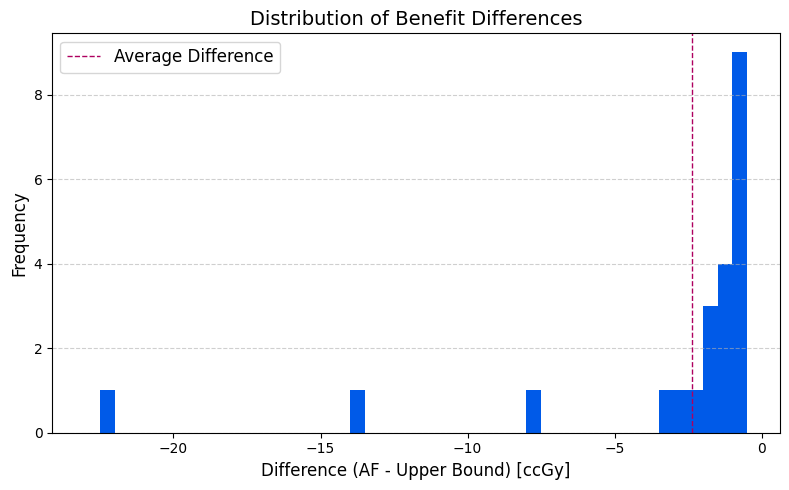

In [ ]:
plt.figure(figsize=(8, 5))
bins = np.arange(-23, 0, 0.5) 
plt.hist(df.loc[~indexes_equal]['benefits'] - df.loc[~indexes_equal]['Upper Bound Benefits'], bins=bins, color=COLORS['blue'])
# plt.hist(df.loc[~indexes_equal]['benefits'] - df.loc[~indexes_equal]['Upper Bound Benefits'], bins=50, color=COLORS['blue'])
plt.xlabel('Difference (AF - Upper Bound) [ccGy]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Benefit Differences', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.axvline(x=np.mean(df.loc[~indexes_equal]['benefits'] - df.loc[~indexes_equal]['Upper Bound Benefits']), color=COLORS['red'], linestyle='--', linewidth=1, label='Average Difference')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
bins

array([-23, -18, -13,  -8,  -3])

In [ ]:
benefits = df['benefits']

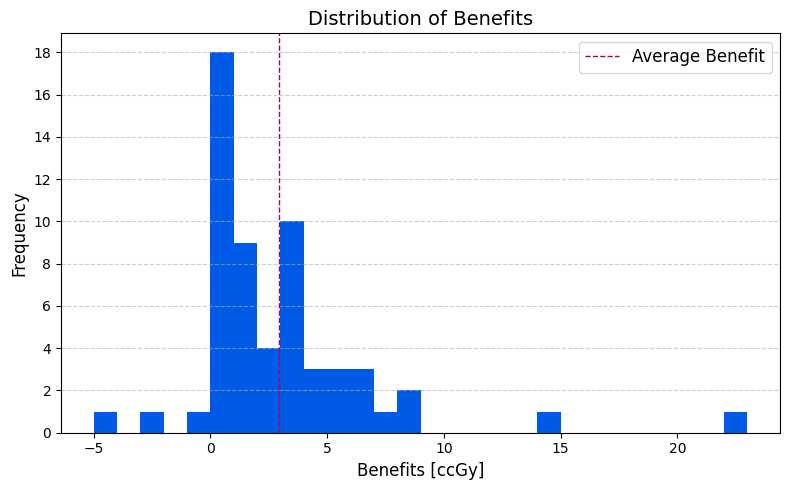

In [ ]:
plt.figure(figsize=(8, 5))
bins = np.arange(-5, 24, 1)
plt.hist(benefits, bins=bins, color=COLORS['blue'])
plt.xlabel('Benefits [ccGy]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Benefits', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.yticks(np.arange(0, 19, 2))
plt.axvline(x=np.mean(benefits), color=COLORS['red'], linestyle='--', linewidth=1, label='Average Benefit')
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()


In [ ]:
benefit_sorted = df.sort_values(by='benefits', ascending=False)
benefit_sorted

,Patient number,Overlaps,Prescription,AF doses,benefits,penalties,Upper Bound Doses,Upper Bound Benefits
2,3.0,"[9.08, 19.79, 6.02, 9.45, 19.59, 12.62]",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",22.422,-18.06,"[6.0, 9.0, 6.0, 6.0, 6.0]",22.422
48,49.0,"[4.27, 5.91, 3.2800000000000002, 3.87, 4.18, 8...",40.0,"[6.0, 10.0, 10.0, 8.0, 6.0]",14.240,-36.96,"[6.0, 10.0, 10.0, 8.0, 6.0]",14.240
13,14.0,"[2.88, 3.35, 3.35, 0.53, 1.92, 3.66]",35.0,"[6.0, 6.0, 10.0, 7.0, 6.0]",8.770,-4.04,"[6.0, 6.0, 10.0, 7.0, 6.0]",8.770
54,55.0,"[3.0, 6.41, 4.13, 4.91, 5.659999999999999, 3.56]",40.0,"[6.0, 10.0, 8.0, 6.0, 10.0]",8.760,-40.58,"[6.0, 10.0, 8.0, 6.0, 10.0]",8.760
6,7.0,"[5.41, 8.2, 9.16, 8.18, 5.45, 7.28]",40.0,"[6.0, 6.0, 10.0, 10.0, 8.0]",7.460,-69.08,"[6.0, 6.0, 8.0, 10.0, 10.0]",9.260
1,2.0,"[6.19, 10.97, 4.91, 7.65, 5.73, 5.87]",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.348,-14.73,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.348
26,27.0,"[5.35, 5.5600000000000005, 3.8499999999999996,...",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.276,-11.55,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.276
7,8.0,"[0.41, 2.37, 0.68, 2.67, 1.62, 1.27]",40.0,"[6.0, 10.0, 6.0, 8.0, 10.0]",6.180,-11.04,"[6.0, 10.0, 6.0, 8.0, 10.0]",6.180
25,26.0,"[2.11, 2.14, 0.87, 3.57, 2.59, 1.91]",35.0,"[6.0, 10.0, 6.0, 6.0, 7.0]",5.690,-5.39,"[6.0, 10.0, 6.0, 6.0, 7.0]",5.690
12,13.0,"[4.79, 6.28, 8.71, 6.39, 5.97, 8.3]",35.0,"[6.0, 6.0, 7.0, 10.0, 6.0]",5.380,-30.27,"[7.0, 6.0, 6.0, 10.0, 6.0]",5.490


In [ ]:
df.sort_values(by='Prescription', inplace=True)

count    58.000000
mean      2.934414
std       3.945425
min      -4.440000
25%       0.738500
50%       1.960000
75%       3.947500
max      22.422000
Name: benefits, dtype: float64

In [ ]:
patients_of_interest = [2,13,17,24,25,48]
for patient in patients_of_interest:
    print('mean: ', overlap_array[patient].mean())
    print('std; ', overlap_array[patient].std())

mean:  12.758333333333335
std;  5.260156577728672
mean:  2.6149999999999998
std;  1.0857370768284558
mean:  0.8866666666666667
std;  0.5728777259493415
mean:  0.33
std;  0.2630589287593181
mean:  2.1983333333333333
std;  0.8055726051835563
mean:  4.9783333333333335
std;  1.7105302946422456
